## What is a machine learning research paper?

A machine learning research paper is a scientific paper that details findings of a research group on a specific area.

The contents of a machine learning research paper can vary from paper to paper but they generally follow the structure:

| **Section** | **Contents** |
| ----- | ----- | 
| **Abstract** | An overview/summary of the paper's main findings/contributions. |
| **Introduction** | What's the paper's main problem and details of previous methods used to try and solve it. |
| **Method** | How did the researchers go about conducting their research? For example, what model(s), data sources, training setups were used? |
| **Results** | What are the outcomes of the paper? If a new type of model or training setup was used, how did the results of findings compare to previous works? (this is where **experiment tracking** comes in handy) |
| **Conclusion** | What are the limitations of the suggested methods? What are some next steps for the research community? |
| **References** | What resources/other papers did the researchers look at to build their own body of work? |
| **Appendix** | Are there any extra resources/findings to look at that weren't included in any of the above sections? |

## What we are going to cover?

- Getting Setup

- Introduction machine learning paper replicating weith Pytorch

- Replicating ViT for Foodvisio nMini

- Training ViT

- Feature Exrtaction with pretrained ViT

# PyTorch Paper Replicating

The goal of machine learning research paper replicating is to turn a ML research paper into usable code

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch : https://paperswithcode.com/paper/an-image-is-worth-16x16-words-transformers-1

## Get Setup

Let's import code we've previously written + rquired libaries

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.3.0
torchvision version: 0.18.0


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import *
    from helper_functions import *
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import *
    from helper_functions import *

In [3]:
!nvidia-smi

Thu May 30 17:56:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:26:00.0  On |                  N/A |
|  0%   47C    P8              10W / 170W |   1152MiB / 12288MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get data 

The whole goal of what we're trying to do is replicate the ViT archiecture for our foodvision mini problem.

To do that, we need some data

Namely the pizza, steak, and sucshi images we've been using so far...

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Create Datasets and DataLoaders

In [8]:
from going_modular.going_modular import data_setup

In [9]:
IMG_SIZE = 224
manual_transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor()
    ]
)
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [10]:
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE
)

In [11]:
len(train_dataloader),len(test_dataloader),class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## Visualize Images

In [12]:
imgs,labels = next(iter(train_dataloader))

In [13]:
import random

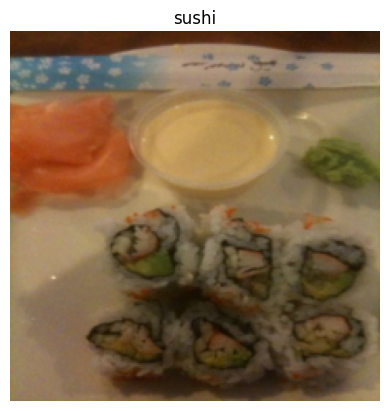

In [14]:
rdm_no = random.randint(0,len(labels)-1)
plt.figure()
plt.imshow(imgs[rdm_no].permute(1,2,0))
plt.title(class_names[labels[rdm_no]])
plt.axis(False)
plt.show()

## 3. Replicating ViT: Overview

Looking at a whole ML research paper can be initimidating, so in order to make it more understandable, we can break it down into smaller pieaces.

- **Inputs**: What goes sinto the model? (image tensors)
- **Outputs**: What comes out of the model/layer/block? (Image classification labels)
- **Layers**: Takes an input, manipulates it with a function (such as self attention)
- **Blocks**: Collection of layers.
- **Model (or architecture)**: Collection of blocks.

### 3.1 ViT overview : Pieaces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer / block
* Table 1/3: Hyperparameters for the architecture/training.
* Text

### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embeeding: Learnable representation (start with random numbers and improve over time)
* MLP : Multilayer preceptron

### Four Equations

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

#### Section 3.1

##### Equation 1
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

##### Equation 1
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos]
```
---

##### Equation 2&3
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_Layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

##### Equation 4
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

### Table 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)